# **Evaluating a RAG Application using Qdrant and RAGAS using DSPy**

**Introduction**

Creating a foundation for a Retrieval-Augmented Generation (RAG) pipeline is often straightforward. However, optimizing and tweaking it for production and ensuring top-notch response quality presents formidable hurdles. Given the multitude of tools and parameters available, identifying the ideal configuration can feel overwhelming.

In this notebook, we delve into the evaluation, visualization, and analysis of RAG systems using a blend of open-source libraries. 
Our toolkit includes [RAGAS](https://docs.ragas.io/) for evaluation and Qdrant for context augmentation, serving as a vector database to construct the RAG pipeline using [DSPy](https://github.com/stanfordnlp/dspy).

Throughout this article, we'll leverage data sourced from [Qdrant](https://qdrant.tech/)'s documentation and articles to create an assistant capable of answering queries about Qdrant. Additionally, we'll explore methods for generating synthetic test data provided by RAGAS.

❗This notebook requires **OpenAI Key**

### **1. Import relevant packages**

In [1]:
import os
import json
import openai
import pandas as pd
import qdrant_client
from getpass import getpass
from dotenv import load_dotenv
from tqdm.notebook import tqdm
from datasets import load_dataset
from typing import Optional, List, Tuple
from qdrant_client import QdrantClient, models
from qdrant_client.http.models import PointStruct
from langchain_core.language_models import BaseChatModel

In [2]:
load_dotenv()

True

### **2. Setup your openai key**

In [3]:
if not (openai_api_key := os.environ.get("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
openai.api_key = openai_api_key
os.environ["OPENAI_API_KEY"] = openai_api_key

### **3.  Retrieve the documents / dataset to be used**

In [4]:

dataset = load_dataset("atitaarora/qdrant_doc", split="train")


### **4. Process dataset as langchain document for further processing**

In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document as LangchainDocument

## Dataset to langchain document
langchain_docs = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]})
    for doc in tqdm(dataset)
]

len(langchain_docs)

  0%|          | 0/240 [00:00<?, ?it/s]

240

### **5. Test Evaluation Dataset Generation using Ragas**

In [ ]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# generator with openai models
generator_llm = ChatOpenAI(model="gpt-3.5-turbo-16k")
critic_llm = ChatOpenAI(model="gpt-4")
embeddings = OpenAIEmbeddings()

generator = TestsetGenerator.from_langchain(generator_llm , critic_llm , embeddings)

# generate testset
testset = generator.generate_with_langchain_docs(langchain_docs[:10], test_size=10, 
                                                 distributions={simple: 0.5, reasoning: 0.25, multi_context: 0.25})

### **5a. Evaluation dataset to Pandas for better visualization**

In [8]:
df = testset.to_pandas()
df.head(10)

,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,How do you load data into a Qdrant collection?,[---\n\ntitle: Quickstart\n\nweight: 11\n\nali...,"To load data into a Qdrant collection, you can...",simple,[{'source': 'documentation/quick-start.md'}],True
1,What is the purpose of the query vector in the...,[;\n\n\n\nvar operationInfo = await client.Ups...,nan,simple,"[{'source': 'documentation/quick-start.md'}, {...",True
2,How does the multi-language model help in cate...,[---\n\ndraft: false\n\ntitle: E-commerce prod...,nan,simple,[{'source': 'demo/demo-3.md'}],True
3,What is the purpose of the Food Discovery Demo...,[---\n\ndraft: false\n\ntitle: Food Discovery\...,This demo uses data from Delivery Service. Use...,simple,[{'source': 'demo/demo-2.md'}],True
4,What is the Basic RAG pipeline and how does it...,[ for Skin Conditions](https://colab.research....,Basic RAG pipeline is a pipeline that incorpor...,simple,[{'source': 'documentation/examples.md'}],True
5,"What does the ""limit"" parameter do in the quer...",[;\n\n\n\nvar operationInfo = await client.Ups...,nan,reasoning,"[{'source': 'documentation/quick-start.md'}, {...",True
6,How does the Qdrant Startup Search demo perfor...,[---\n\ndraft: false\n\ntitle: Startup Search\...,This demo uses short descriptions of startups ...,reasoning,[{'source': 'demo/demo-1.md'}],True
7,How does the Qdrant Startup Search demo use sh...,[---\n\ndraft: false\n\ntitle: Startup Search\...,This demo uses short descriptions of startups ...,multi_context,[{'source': 'demo/demo-1.md'}],True
8,What community resources are available for bui...,[---\n\ntitle: Community links\n\nweight: 42\n...,The community resources available for building...,multi_context,[{'source': 'documentation/community-links.md'}],True
9,How does the multi-language model help categor...,[---\n\ndraft: false\n\ntitle: E-commerce prod...,nan,multi_context,[{'source': 'demo/demo-3.md'}],True


### **5b. Export the evaluation dataset to csv (if needed)**

In [9]:
from pathlib import Path
filepath = Path('sample_question_ragas_101.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(filepath)

### **6. Document chunk processing**

Processing each document with desired **TEXT_SPLITTER_ALGO , CHUNK_SIZE , CHUNK_OVERLAP** etc

In [6]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=512,
    chunk_overlap=50,
    add_start_index=True,
    separators=["\n\n", "\n", ".", " ", ""],
)

docs_processed = []
for doc in langchain_docs:
    docs_processed += text_splitter.split_documents([doc])

### **7. Setting up Qdrant**

Set up the qdrant client and then create a collection so that our documents can be stored.

In [7]:

##Uncomment to initialise qdrant client in memory
#client = qdrant_client.QdrantClient(
#    location=":memory:",
#)

##Uncomment below to connect to Qdrant Cloud
client = qdrant_client.QdrantClient(
    os.environ.get("QDRANT_URL"),
    api_key=os.environ.get("QDRANT_API_KEY"),
)

## Uncomment below to connect to local Qdrant
#client = qdrant_client.QdrantClient("http://localhost:6333")

In [8]:
## Collection name that will be used throughtout in the notebook
COLLECTION_NAME = "qdrant-docs-ragas"

In [9]:
## General Collection level operations

## Get information about existing collections
client.get_collections()

## Get information about specific collection
#collection_info = client.get_collection(COLLECTION_NAME)
#print(collection_info)

## Deleting collection , if need be
#client.delete_collection(COLLECTION_NAME)

CollectionsResponse(collections=[CollectionDescription(name='qdrant_docs_arize_hybrid'), CollectionDescription(name='experiment_512_64_all-MiniLM-L6-v2'), CollectionDescription(name='qdrant-docs-ragas-haystack-mxbai'), CollectionDescription(name='experiment_1024_128_bge-small-en'), CollectionDescription(name='qdrant_docs_arize_dense'), CollectionDescription(name='qdrant-docs-ragas'), CollectionDescription(name='email'), CollectionDescription(name='qdrant-docs-ragas-haystack-mxbai-livestream'), CollectionDescription(name='qdrant-docs-semantic-chunked'), CollectionDescription(name='hybrid_experiment_512_64_bge-small-en'), CollectionDescription(name='experiment_512_64_bge-small-en')])

In [10]:
## Declaring the intended Embedding Model with Fastembed
from fastembed.embedding import TextEmbedding

pd.DataFrame(TextEmbedding.list_supported_models())

2024-07-04 14:02:35.403 | WARNING  | fastembed.embedding:<module>:7 - DefaultEmbedding, FlagEmbedding, JinaEmbedding are deprecated.Use from fastembed import TextEmbedding instead.


,model,dim,description,size_in_GB,sources
0,BAAI/bge-base-en,768,Base English model,0.420,{'url': 'https://storage.googleapis.com/qdrant...
1,BAAI/bge-base-en-v1.5,768,"Base English model, v1.5",0.210,{'url': 'https://storage.googleapis.com/qdrant...
2,BAAI/bge-large-en-v1.5,1024,"Large English model, v1.5",1.200,{'hf': 'qdrant/bge-large-en-v1.5-onnx'}
3,BAAI/bge-small-en,384,Fast English model,0.130,{'url': 'https://storage.googleapis.com/qdrant...
4,BAAI/bge-small-en-v1.5,384,Fast and Default English model,0.067,{'hf': 'qdrant/bge-small-en-v1.5-onnx-q'}
5,BAAI/bge-small-zh-v1.5,512,Fast and recommended Chinese model,0.090,{'url': 'https://storage.googleapis.com/qdrant...
6,sentence-transformers/all-MiniLM-L6-v2,384,"Sentence Transformer model, MiniLM-L6-v2",0.090,{'url': 'https://storage.googleapis.com/qdrant...
7,sentence-transformers/paraphrase-multilingual-...,384,"Sentence Transformer model, paraphrase-multili...",0.220,{'hf': 'qdrant/paraphrase-multilingual-MiniLM-...
8,nomic-ai/nomic-embed-text-v1,768,8192 context length english model,0.520,{'hf': 'nomic-ai/nomic-embed-text-v1'}
9,nomic-ai/nomic-embed-text-v1.5,768,8192 context length english model,0.520,{'hf': 'nomic-ai/nomic-embed-text-v1.5'}


In [11]:
##Initilising embedding model
## Using Default Model - BAAI/bge-small-en-v1.5
#embedding_model = TextEmbedding()

## For custom model supported by Fastembed
#embedding_model = TextEmbedding(model_name="BAAI/bge-small-en", max_length=512)
embedding_model = TextEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2", max_length=384)

embedding_model.model_name

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

'sentence-transformers/all-MiniLM-L6-v2'

### **8. Processing chunks into text to be processed by [FASTEMBED](https://qdrant.github.io/fastembed/)**

In [16]:
docs_contents = []
docs_metadatas = []

for doc in docs_processed:
    if hasattr(doc, 'page_content') and hasattr(doc, 'metadata'):
        docs_contents.append(doc.page_content)
        docs_metadatas.append(doc.metadata)
    else:
        # Handle the case where attributes are missing
        print("Warning: Some documents do not have 'page_content' or 'metadata' attributes.")

print("content : ",len(docs_contents))
print("metadata : ",len(docs_metadatas))

content :  4431
metadata :  4431


### **9. Adding document chunks into Qdrant Collection**

In [17]:
client.add(collection_name=COLLECTION_NAME, metadata=docs_metadatas, documents=docs_contents)

100%|██████████████████████████████████████████████████████████████████████████████████████| 77.7M/77.7M [00:19<00:00, 4.08MiB/s]


['ab2e436dc7a54f88a36decf9a767b205',
 '1c338ae0388845e281aadd127f62d827',
 '93e5d106eedd49bead2c7594966047f0',
 '143eeed777ac4f319008c60c0ba58cdd',
 '518f7d4f88c247298ff3feb4080f625d',
 'e2fb0f43a3af41038a6285046f8125e6',
 'ccf97ddfa98e43d4aa524e96144e4fc4',
 '921461da8a614c90bcae411ec407fa0b',
 '110b058859b54952b7a25e19f4601b39',
 'b17f85b8e75b479caa3e8f30a70906b9',
 '42ec6d70abaf4d158eb5b291c614801c',
 '550ef9a7adf642a4aca08b82ddcf957f',
 '71927d1fbd7641ccb2adc7e3375ebe54',
 '4fe7527f5f4645ed81411ca8cdcdb307',
 '1f10e9c5e5844dadba647d8e013472c2',
 '592cbf2996ef4fbbb54d2c4611fcac2f',
 '7da36de6c7764c8d95a5c785892542cd',
 '39140fc65d90450d832f4e09cf03bb35',
 '393cc799b25d49b0b626dee11311683e',
 'c5793ca6d2924d1897302a588245375a',
 '6fb10d5042bb4b82976741da3c6ef4ef',
 '4255d7cf11e44bbc98fed0916518f733',
 'fdc04a68d34e401ebfefe0ab3880c63a',
 '3bb21818fb8243f49c481df2f049b746',
 '4ccdcdbac8e24504b17b67ae61178e17',
 '81145214a1a24c6484bf4c592652387b',
 'f06920a51183488c8d367f0417c1ba5c',
 

In [12]:
## Ensuring we have expected number of document chunks
client.count(collection_name=COLLECTION_NAME)

CountResult(count=4431)

### **10. Searching for the document**

In [13]:
## Searching for document chunks similar to query for context
search_result = client.query(collection_name=COLLECTION_NAME, query_text="what is binary quantization",limit=2)
context = ["document:"+r.document+",source:"+r.metadata['source'] for r in search_result]
for res in search_result:
    print("Id: ", res.id)
    print("Document : " , res.document)
    print("Score : " , res.score)
    print("Source : " , res.metadata['source'])

100%|████████████████████████████████████████████████████████████████████████| 77.7M/77.7M [00:07<00:00, 9.94MiB/s]


Id:  8b1d6591-1ab3-44d1-b50c-83c23aeb9b21
Document :  Here, we show how the accuracy of binary quantization is quite good across different dimensions -- for both the models. 



## Enhanced Performance and Efficiency with Binary Quantization
Score :  0.93278515
Source :  articles/binary-quantization-openai.md
Id:  d712ca08-cc4b-41f0-a592-7c0a06b8945c
Document :  Demetrios:

I see, okay, so basically this is the quantization. And now let's dive into the binary quantization and how it works.



Andrey Vasnetsov:
Score :  0.9211245
Source :  blog/binary-quantization-andrey-vasnetsov-vector-space-talk-001.md


### **11. Inititalize OpenAI**

In [14]:
from openai import OpenAI
openai_client = OpenAI(api_key=openai_api_key)

### **12. Querying without the context**

In [15]:
def query_without_context(query):

    prompt_start = (
        """ You're assisting a user who has a question based on the documentation.
        Your goal is to provide a clear and concise response that addresses their query while referencing relevant information 
        from the documentation.
        Remember to: 
        Understand the user's question thoroughly.
        If the user's query is general (e.g., "hi," "good morning"), 
        greet them normally and avoid using the context from the documentation.
        If the user's query is specific and related to the documentation, locate and extract the pertinent information.
        Craft a response that directly addresses the user's query and provides accurate information
        referring the relevant source and page from the 'source' field of fetched context from the documentation to support your answer.
        Use a friendly and professional tone in your response.
        If you cannot find the answer in the provided context, do not pretend to know it.
        Instead, respond with "I don't know".\n """
    )

    prompt_end = ( f"\n\nQuestion: {query}\nAnswer:" )

    prompt = ( prompt_start + "\n\n---\n\n" +  prompt_end )

    res = openai_client.completions.create(
        model="gpt-3.5-turbo-instruct",
        prompt=prompt,
        temperature=0,
        max_tokens=636,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop=None
    )
    return (res.choices[0].text)

In [16]:
print (query_without_context(query = "what is binary quantization?"))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 Binary quantization is a process of converting numerical data into binary form, where each value is represented by a sequence of 0s and 1s. This technique is commonly used in machine learning and data compression to reduce the size of data while preserving its essential information. You can learn more about binary quantization and its applications on page 12 of the "Data Compression" section in the documentation.


In [17]:
print (query_without_context(query = "How can one reproduce the benchmark for Open Source vector databases?"))

 To reproduce the benchmark for Open Source vector databases, you can follow the steps outlined in the documentation on page 5 of the 'Benchmarking' section. This section provides detailed instructions on how to set up and run the benchmark, as well as how to interpret the results. Additionally, you can refer to the 'Benchmarking' section on page 4 for more information on the purpose and methodology of the benchmark. If you encounter any issues or have further questions, please refer to the 'Troubleshooting' section on page 6 or reach out to the community for assistance.


### **13. Querying with Context from Qdrant**

In [18]:
def query_with_context(query,limit):

    ## Fetch context from Qdrant
    search_result = client.query(collection_name=COLLECTION_NAME, query_text=query, limit=limit)

    contexts = [
        "document:"+r.document+",source:"+r.metadata['source'] for r in search_result
    ]
    prompt_start = (
        """ You're assisting a user who has a question based on the documentation.
        Your goal is to provide a clear and concise response that addresses their query while referencing relevant information 
        from the documentation.
        Remember to: 
        Understand the user's question thoroughly.
        If the user's query is general (e.g., "hi," "good morning"), 
        greet them normally and avoid using the context from the documentation.
        If the user's query is specific and related to the documentation, locate and extract the pertinent information.
        Craft a response that directly addresses the user's query and provides accurate information
        referring the relevant source and page from the 'source' field of fetched context from the documentation to support your answer.
        Use a friendly and professional tone in your response.
        If you cannot find the answer in the provided context, do not pretend to know it.
        Instead, respond with "I don't know".
        
        Context:\n"""
    )

    prompt_end = (
        f"\n\nQuestion: {query}\nAnswer:"
    )

    prompt = (
        prompt_start + "\n\n---\n\n".join(contexts) +
        prompt_end
    )

    res = openai_client.completions.create(
        model="gpt-3.5-turbo-instruct",
        prompt=prompt,
        temperature=0,
        max_tokens=636,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop=None
    )

    return (contexts , res.choices[0].text)

In [24]:
question1 = "what is quantization?"
question2 = "How can one reproduce the benchmark for Open Source vector databases?"
RETRIEVAL_WINDOW_SIZE_3 = 3
RETRIEVAL_WINDOW_SIZE_5 = 5

#### **Let's try our RAG pipeline with `Question 1` and `Question 2` along with `3 and 5 as number of retrieved documents` to see the impact of size of `CONTEXT`**

In [20]:
## Question 1 ; Context Size - 3
context1 , rag_response1 = query_with_context(question1,RETRIEVAL_WINDOW_SIZE_3)
#print(context)
print(rag_response1)

 Quantization is a technique that uses quantum computing to improve the search process in artificial neural networks (ANNs). It involves converting traditional float32 vectors into qbit vectors and creating quantum entanglement between them. This allows for highly efficient vector search algorithms to be developed. This information can be found in the article "Quantum Quantization and Entanglement" in the 'articles' section of the documentation.


In [19]:
## Question 1 ; Context Size - 5
context2 , rag_response2 = query_with_context(question1,RETRIEVAL_WINDOW_SIZE_5)
#print(context)
print(rag_response2)

 Quantization is an optional feature in Qdrant that enables efficient storage and search of high-dimensional vectors. It compresses data while preserving relative distances between vectors, making vector search algorithms more efficient. This is explained in more detail in the documentation on Quantum Quantization and Entanglement, specifically in the section on Quantization.


In [21]:
## Question 2 ; Context Size - 3
context2_1 , rag_response2_1 = query_with_context(question2,RETRIEVAL_WINDOW_SIZE_3)
#print(context)
print(rag_response2_1)

 To reproduce the benchmark for Open Source vector databases, you can refer to the source code available on Github and follow the instructions in the README.md file. The benchmarks are fully open-sourced and contributions are welcome. This information can be found in the 'How to reproduce the benchmark?' section of the 'benchmarks/benchmark-faq.md' page.


In [22]:
## Question 2 ; Context Size - 5
context2_1 , rag_response2_1 = query_with_context(question2,RETRIEVAL_WINDOW_SIZE_5)
#print(context)
print(rag_response2_1)

 To reproduce the benchmark for Open Source vector databases, you can refer to the source code available on Github and follow the instructions in the README.md file. This information can be found in the document titled "The Emergence and Relevance of Vector Databases" in the blog/series-A-funding-round.md file.


**As noticed, the quality of response does get worse with larger context length.**

### **13.1 Querying with Context from Qdrant with DSPy**

In [14]:
#!pip install "dspy-ai[qdrant]"

In [28]:
import dspy
from dspy.retrieve.qdrant_rm import QdrantRM

turbo = dspy.OpenAI(model="gpt-3.5-turbo")
qdrant_retriever_model = QdrantRM(COLLECTION_NAME, client, k=3)

dspy.settings.configure(lm=turbo, rm=qdrant_retriever_model)

retrieve = dspy.Retrieve(k=3)

In [32]:
topK_passages = retrieve(question2).passages

print(f"Top {retrieve.k} passages for question: {question2}", "\n")
for idx, passage in enumerate(topK_passages):
    print(f"{idx+1}]", passage, "\n")

Top 3 passages for question: How can one reproduce the benchmark for Open Source vector databases? 

1] ## The Emergence and Relevance of Vector Databases 

2] That makes the comparison unfair. That’s why we purely focused on testing the Open Source vector databases, so everybody may reproduce the benchmarks easily.



This is not the final list, and we’ll continue benchmarking as many different engines as possible.



## How to reproduce the benchmark?



The source code is available on [Github](https://github.com/qdrant/vector-db-benchmark) and has a `README.md` file describing the process of running the benchmark for a specific engine. 

3] However, we tried our best, kept scrolling the docs up and down, experimented with combinations of different configurations, and gave all of them an equal chance to stand out. If you believe you can do it better than us, our **benchmarks are fully [open-sourced](https://github.com/qdrant/vector-db-benchmark), and contributions are welcome**!






In [44]:
import dspy
from dspy.retrieve.qdrant_rm import QdrantRM

turbo = dspy.OpenAI(model="gpt-3.5-turbo")
qdrant_retriever_model = QdrantRM(COLLECTION_NAME, client, k=3)
dspy.settings.configure(lm=turbo, rm=qdrant_retriever_model)

def query_with_DSPy_context(query,limit):

    ## Fetch context from Qdrant using DsPy
    search_result_retrieve = dspy.Retrieve(k=limit)
    search_result = search_result_retrieve(query).passages

    prompt_start = (
        """ You're assisting a user who has a question based on the documentation.
        Your goal is to provide a clear and concise response that addresses their query while referencing relevant information 
        from the documentation.
        Remember to: 
        Understand the user's question thoroughly.
        Think about the question in a step by step approach
        If the user's query is general (e.g., "hi," "good morning"), 
        greet them normally and avoid using the context from the documentation.
        If the user's query is specific and related to the documentation, locate and extract the pertinent information.
        Craft a response that directly addresses the user's query and provides accurate information
        referring the relevant source and page from the 'source' field of fetched context from the documentation to support your answer.
        Use a friendly and professional tone in your response.
        If you cannot find the answer in the provided context, do not pretend to know it.
        Instead, respond with "I don't know".
        
        Context:\n"""
    )

    prompt_end = (
        f"\n\nQuestion: {query}\nAnswer:"
    )

    prompt = (
        prompt_start + "\n\n---\n\n".join(search_result) +
        prompt_end
    )

    res = openai_client.completions.create(
        model="gpt-3.5-turbo-instruct",
        prompt=prompt,
        temperature=0,
        max_tokens=636,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop=None
    )

    return (search_result , res.choices[0].text)

In [46]:
question2 = "How can one reproduce the benchmark for Open Source vector databases?"
print(query_with_DSPy_context(question2,RETRIEVAL_WINDOW_SIZE_3)[1])

 To reproduce the benchmark for Open Source vector databases, you can follow the instructions provided in the README.md file on the Github repository for the benchmark. The source code is also available on Github, and contributions are welcome. The benchmarks measure several factors, which are described in detail in the documentation.


In [47]:
print(query_with_DSPy_context(question2,2)[1])

 To reproduce the benchmark for Open Source vector databases, you can follow the steps outlined in the `README.md` file on the [Github](https://github.com/qdrant/vector-db-benchmark) page. This includes downloading the source code and following the instructions provided for running the benchmark for a specific engine. This process allows for easy reproduction of the benchmarks for various engines.


### **14. Prepare the evaluation dataset to evaluate our RAG system**

In [48]:
from datasets import Dataset

# RAGAS Expect ['question', 'answer', 'contexts', 'ground_truths'] format
'''
{
    "question": ['What is quantization?', ...],
    "answer": [], ## answer
    "contexts": [], ## context
    "ground_truth": ## answer expected
}
'''
def create_eval_dataset(dataset, eval_size,retrieval_window_size):
    questions = []
    answers = []
    contexts = []
    ground_truths = []
    
    # Iterate over the first 10 entries
    for i in range(eval_size):
        entry = dataset[i]
        question = entry['question']
        answer = entry['answer']
        questions.append(question)
        ground_truths.append(answer)
        context , rag_response = query_with_context(question,retrieval_window_size)
        contexts.append(context)
        answers.append(rag_response)
    
    rag_response_data = {
        "question": questions,
        "answer": answers,
        "contexts": contexts,
        "ground_truth": ground_truths
    }
    
    return rag_response_data


def create_eval_dataset_for_dspy(dataset, eval_size,retrieval_window_size):
    questions = []
    answers = []
    contexts = []
    ground_truths = []
    
    # Iterate over the first 10 entries
    for i in range(eval_size):
        entry = dataset[i]
        question = entry['question']
        answer = entry['answer']
        questions.append(question)
        ground_truths.append(answer)
        context , rag_response = query_with_DSPy_context(question,retrieval_window_size)
        contexts.append(context)
        answers.append(rag_response)
    
    rag_response_data = {
        "question": questions,
        "answer": answers,
        "contexts": contexts,
        "ground_truth": ground_truths
    }
    
    return rag_response_data

In [49]:
## Define the Config for generating the Eval dataset as below :

## The dataset used to evaluate RAG using RAGAS
## loading the eval dataset from HF
qdrant_qna_dataset = load_dataset("atitaarora/qdrant_doc_qna", split="train")

EVAL_SIZE = 10

#for Exp 1
RETRIEVAL_SIZE_2 = 2

#for Exp 2
RETRIEVAL_SIZE_3 = 3

In [50]:
## Generating Eval dataset for the given RAG pipeline
## Note this is the dataset needed for evaluation hence has to be recreated everytime changes to RAG config is made

rag_eval_dataset_dspy_512_2 = create_eval_dataset_for_dspy(qdrant_qna_dataset,EVAL_SIZE,RETRIEVAL_SIZE_2)
rag_eval_dataset_dspy_512_2

{'question': ['What is vaccum optimizer ?',
  'Tell me about ‘always_ram’ parameter?',
  'What is difference between scalar and product quantization?',
  'What is ‘best_score’ strategy?',
  'How does oversampling helps?',
  'What is the purpose of ‘CreatePayloadIndexAsync’?',
  'What is the purpose of ef_construct in HNSW ?',
  'How do you use ‘ordering’ parameter?',
  'What is significance of ‘on_disk_payload’ setting?',
  'What is the impact of ‘write_consistency_factor’ ?'],
 'answer': [' The vacuum optimizer is a tool used to optimize the performance of a database by removing unused or redundant data. It works by identifying and removing empty or outdated data, freeing up space and improving the overall efficiency of the database. This can help improve the speed and reliability of queries and reduce the amount of storage needed for the database. You can learn more about the vacuum optimizer and how to use it in the documentation on optimization with web workers, specifically in the

In [51]:
rag_response_dataset_dspy_512_2 = Dataset.from_dict(rag_eval_dataset_dspy_512_2)
rag_response_dataset_dspy_512_2.to_csv('rag_response_with_dspy_512_2.csv')

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

18501

In [52]:
## Generating Eval dataset for the given RAG pipeline
## Note this is the dataset needed for evaluation hence has to be recreated everytime changes to RAG config is made

rag_eval_dataset_dspy_512_3 = create_eval_dataset_for_dspy(qdrant_qna_dataset,EVAL_SIZE,RETRIEVAL_SIZE_3)
rag_eval_dataset_dspy_512_3

{'question': ['What is vaccum optimizer ?',
  'Tell me about ‘always_ram’ parameter?',
  'What is difference between scalar and product quantization?',
  'What is ‘best_score’ strategy?',
  'How does oversampling helps?',
  'What is the purpose of ‘CreatePayloadIndexAsync’?',
  'What is the purpose of ef_construct in HNSW ?',
  'How do you use ‘ordering’ parameter?',
  'What is significance of ‘on_disk_payload’ setting?',
  'What is the impact of ‘write_consistency_factor’ ?'],
 'answer': [' The vacuum optimizer is a feature that helps to optimize the performance of the database by removing unused or deleted data from the database. This is done by setting a threshold for the amount of deleted data that can be present in the database before it is removed. This information can be found in the "optimizer_config" section of the documentation, specifically under the "deleted_threshold" key. For more information, please refer to page 5 of the \'source\' field of fetched context from the docu

In [53]:
rag_response_dataset_dspy_512_3 = Dataset.from_dict(rag_eval_dataset_dspy_512_3)
rag_response_dataset_dspy_512_3.to_csv('rag_response_with_dspy_512_3.csv')

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

23037

### **15. Lets evaluate , how good is our RAG !!**

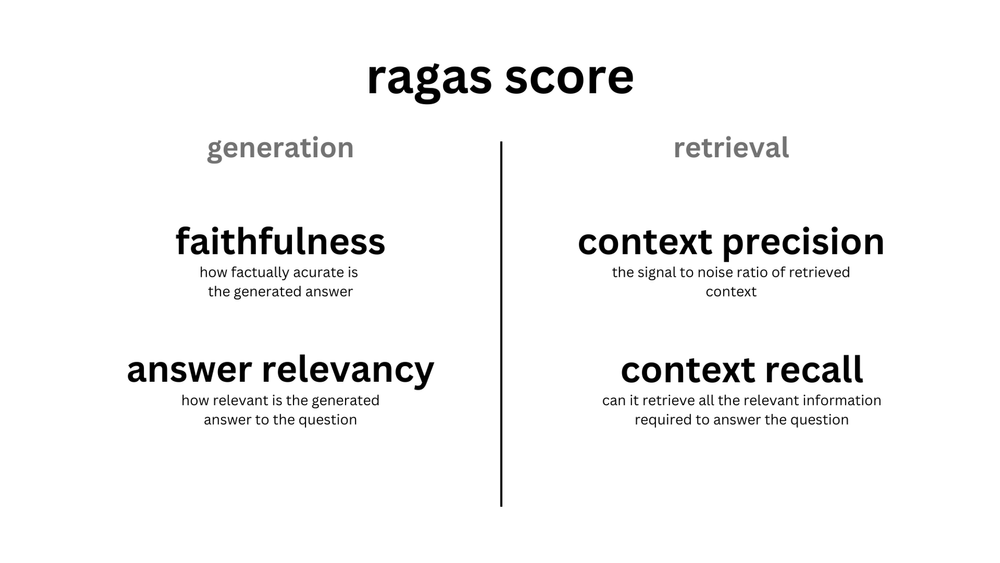

In [54]:
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    context_relevancy,
    context_entity_recall,
    answer_similarity,
    answer_correctness
)

In [55]:
## Method to encapsulate ragas evaluate method with all the 8 metrics
def evaluate_with_ragas(rag_response_dataset_df):
    result = evaluate(
        rag_response_dataset_df,
        metrics=[
                faithfulness,
                answer_relevancy,
                context_recall,
                context_precision,
                context_relevancy,
                context_entity_recall,
                answer_similarity,
                answer_correctness
        ],
       raise_exceptions=False 
    )
    return result

### **16. Evaluation of RAG with Retrieval Window = 2**

In [56]:
## Evaluating Experiment 1 - With Retrieval Window = 2

from ragas import evaluate
eval_dataset_with_dspy_512_2 = pd.read_csv('rag_response_with_dspy_512_2.csv')
eval_dataset_with_dspy_512_2.head(10)

,question,answer,contexts,ground_truth
0,What is vaccum optimizer ?,The vacuum optimizer is a tool used to optimi...,['optimizersConfig: new OptimizersConfigDiff {...,The Vacuum Optimizer is a feature in the Qdran...
1,Tell me about ‘always_ram’ parameter?,The `always_ram` parameter is used to determi...,"['""compression"": ""x32"",\n\n ...",In the context of vector quantization in Qdran...
2,What is difference between scalar and product ...,Scalar quantization is a method of converting...,['But there are some tradeoffs. Product quanti...,While both methods aim to reduce the memory fo...
3,What is ‘best_score’ strategy?,The 'best_score' strategy is a method used to...,"['# [ScoredPoint(id=3, version=0, score=0.09...",The `best_score` strategy is based on the idea...
4,How does oversampling helps?,Oversampling helps by equalizing the represen...,['oversampling helps equalize the representati...,Defines how many extra vectors should be pre-s...
5,What is the purpose of ‘CreatePayloadIndexAsync’?,The 'CreatePayloadIndexAsync' function is use...,['```java\n\nimport io.qdrant.client.QdrantCli...,CreatePayloadIndexAsync is a method in the Qdr...
6,What is the purpose of ef_construct in HNSW ?,The ef_construct parameter in HNSW is used to...,"['(""my_vector"".into()),\n\n ...",In HNSW algorithm the ef_construct parameter i...
7,How do you use ‘ordering’ parameter?,"To use the 'ordering' parameter, you need to ...",['```http\n\nPUT /collections/{collection_name...,Write ordering can be specified for any write ...
8,What is significance of ‘on_disk_payload’ sett...,The 'on_disk_payload' setting is used to defi...,['* `on_disk_payload` - defines where to store...,The `on_disk_payload` setting in the storage c...
9,What is the impact of ‘write_consistency_facto...,The 'write_consistency_factor' determines the...,['### Write consistency factor\n\n\n\nThe `wri...,The `write_consistency_factor` parameter in a ...


In [59]:
result_512_with_dspy_2 = evaluate(
        rag_response_dataset_dspy_512_2,
        metrics=[
                faithfulness,
                answer_relevancy,
                context_recall,
                context_precision,
                context_relevancy,
                context_entity_recall,
                answer_similarity,
                answer_correctness
        ],
       raise_exceptions=False 
    )

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

In [60]:
evaluation_result_df_512_with_dspy_2 = result_512_with_dspy_2.to_pandas()
evaluation_result_df_512_with_dspy_2.iloc[:10]

/Users/atitaarora/qdrant/workspace/qdrant-rag-eval/workshop-rag-eval-qdrant-ragas/ragas/lib/python3.10/site-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/Users/atitaarora/qdrant/workspace/qdrant-rag-eval/workshop-rag-eval-qdrant-ragas/ragas/lib/python3.10/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


,question,answer,contexts,ground_truth,faithfulness,answer_relevancy,context_recall,context_precision,context_relevancy,context_entity_recall,answer_similarity,answer_correctness
0,What is vaccum optimizer ?,The vacuum optimizer is a tool used to optimi...,[optimizersConfig: new OptimizersConfigDiff { ...,The Vacuum Optimizer is a feature in the Qdran...,1.000000,0.957428,0.000000,1.0,0.250000,0.000000,0.898055,0.360877
1,Tell me about ‘always_ram’ parameter?,The `always_ram` parameter is used to determi...,"[""compression"": ""x32"",\n\n ...",In the context of vector quantization in Qdran...,1.000000,0.914733,0.666667,1.0,0.148148,0.142857,0.935302,0.733826
2,What is difference between scalar and product ...,Scalar quantization is a method of converting...,[But there are some tradeoffs. Product quantiz...,While both methods aim to reduce the memory fo...,1.000000,0.920023,1.000000,1.0,0.200000,0.230769,0.921613,0.680403
3,What is ‘best_score’ strategy?,The 'best_score' strategy is a method used to...,"[# [ScoredPoint(id=3, version=0, score=0.09,...",The `best_score` strategy is based on the idea...,0.750000,0.977437,0.000000,1.0,0.166667,0.000000,0.951858,0.647055
4,How does oversampling helps?,Oversampling helps by equalizing the represen...,[oversampling helps equalize the representatio...,Defines how many extra vectors should be pre-s...,0.600000,0.983625,0.500000,0.5,0.250000,0.142857,0.807052,0.535096
5,What is the purpose of ‘CreatePayloadIndexAsync’?,The 'CreatePayloadIndexAsync' function is use...,[```java\n\nimport io.qdrant.client.QdrantClie...,CreatePayloadIndexAsync is a method in the Qdr...,0.666667,0.893574,1.000000,1.0,0.027778,0.000000,0.904508,0.559438
6,What is the purpose of ef_construct in HNSW ?,The ef_construct parameter in HNSW is used to...,"[(""my_vector"".into()),\n\n ...",In HNSW algorithm the ef_construct parameter i...,1.000000,0.955200,0.333333,1.0,0.027778,0.125000,0.906901,0.772177
7,How do you use ‘ordering’ parameter?,"To use the 'ordering' parameter, you need to ...",[```http\n\nPUT /collections/{collection_name}...,Write ordering can be specified for any write ...,0.666667,0.901608,1.000000,1.0,0.020000,0.000000,0.802468,0.800620
8,What is significance of ‘on_disk_payload’ sett...,The 'on_disk_payload' setting is used to defi...,[* `on_disk_payload` - defines where to store ...,The `on_disk_payload` setting in the storage c...,0.600000,0.959801,1.000000,1.0,0.150000,0.083333,0.906335,0.726584
9,What is the impact of ‘write_consistency_facto...,The 'write_consistency_factor' determines the...,[### Write consistency factor\n\n\n\nThe `writ...,The `write_consistency_factor` parameter in a ...,0.750000,0.943122,1.000000,1.0,0.157895,0.357143,0.933992,0.608448


In [40]:

# loading the eval dataset from HF
qdrant_qa = load_dataset("atitaarora/qdrant_docs_qna_ragas")

#Converting contexts string to list of contexts for running further evals
qdrant_qa_eval = load_dataset("atitaarora/qdrant_docs_qna_ragas", split="train")
column_to_filter = "contexts"
# Filter rows with null values in the specified column
filtered_dataset = qdrant_qa_eval.filter(lambda example, column_name=column_to_filter: example[column_name] is not None)
#len(filtered_dataset)

filtered_dataset = filtered_dataset.map(lambda x: {"contexts":[x["contexts"]]})


Generating train split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/81 [00:00<?, ? examples/s]

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

In [41]:
from ragas import evaluate

result_baseline = evaluate(
    filtered_dataset,
    metrics=[
        answer_correctness,
        answer_relevancy,
        faithfulness,
        context_recall,
        context_precision
    ],
)


Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

In [43]:
evaluation_result_df_baseline = result_baseline.to_pandas()
evaluation_result_df_baseline.head(20)

,question,ground_truth,answer,source,contexts,answer_correctness,answer_relevancy,faithfulness,context_recall,context_precision
0,What is the purpose of the locking feature in ...,The locking feature in Qdrant administration t...,The locking feature in Qdrant administration t...,documentation/guides/administration.md,[title: Administration\n\nweight: 10\n\naliase...,1.0,1.000000,1.000000,0.500000,1.0
1,What is the significance of the `on_disk_paylo...,The `on_disk_payload` setting in the storage c...,The `on_disk_payload` setting in the storage c...,documentation/guides/configuration.md,[storage:\n\n # Where to store all the data\n...,1.0,0.953128,1.000000,1.000000,1.0
2,What is the significance of the parameter `max...,The `max_segment_size_kb` parameter in the con...,The `max_segment_size_kb` parameter in the con...,documentation/guides/configuration.md,[default_segment_number: 0\n\n\n\n # Do not...,1.0,0.979010,1.000000,1.000000,1.0
3,What is the significance of the `indexing_thre...,The `indexing_threshold_kb` parameter specifie...,The `indexing_threshold_kb` parameter specifie...,documentation/guides/configuration.md,[memmap_threshold_kb: null\n\n\n\n # Maximu...,1.0,0.969266,1.000000,1.000000,1.0
4,How can you optimize Qdrant for minimizing lat...,To optimize Qdrant for minimizing latency in s...,To optimize Qdrant for minimizing latency in s...,documentation/guides/optimize.md,"[- `exact` - if set to `true`, will perform ex...",1.0,1.000000,1.000000,1.000000,1.0
5,How can Qdrant be configured to optimize throu...,To optimize throughput in Qdrant and utilize m...,To optimize throughput in Qdrant and utilize m...,documentation/guides/optimize.md,[.get();\n\n```\n\n\n\n```csharp\n\nusing Qdra...,1.0,0.924237,1.000000,1.000000,1.0
6,How can one enable distributed deployment mode...,To enable distributed deployment mode in Qdran...,To enable distributed deployment mode in Qdran...,documentation/guides/distributed_deployment.md,[---\n\ntitle: Distributed Deployment\n\nweigh...,1.0,1.000000,1.000000,1.000000,1.0
7,What is the recommended approach for determini...,"When creating a collection using Qdrant, it is...","When creating a collection using Qdrant, it is...",documentation/guides/distributed_deployment.md,[using Qdrant.Client.Grpc;\n\n\n\nvar client =...,1.0,0.967004,1.000000,1.000000,1.0
8,How is the discovery score computed in the con...,"In the context provided, the discovery score i...","In the context provided, the discovery score i...",documentation/concepts/explore.md,"[-1, &\quad s(v^+) < s(v^-)\n\n\end{cases}\n\n...",1.0,0.968043,1.000000,1.000000,1.0
9,How does Qdrant optimize storage at the segmen...,Qdrant optimizes storage at the segment level ...,Qdrant optimizes storage at the segment level ...,documentation/concepts/optimizer.md,[---\n\ntitle: Optimizer\n\nweight: 70\n\nalia...,1.0,1.000000,1.000000,1.000000,1.0


### **17. Evaluation of RAG with Retrieval Window = 3**

In [61]:
## Evaluating Experiment 3 - With Retrieval Window = 3

from ragas import evaluate
eval_dataset_with_dspy_512_3 = pd.read_csv('rag_response_with_dspy_512_3.csv')
eval_dataset_with_dspy_512_3.head(10)

,question,answer,contexts,ground_truth
0,What is vaccum optimizer ?,The vacuum optimizer is a feature that helps ...,['optimizersConfig: new OptimizersConfigDiff {...,The Vacuum Optimizer is a feature in the Qdran...
1,Tell me about ‘always_ram’ parameter?,The `always_ram` parameter is used to determi...,"['""compression"": ""x32"",\n\n ...",In the context of vector quantization in Qdran...
2,What is difference between scalar and product ...,Scalar quantization is a method of compressin...,['But there are some tradeoffs. Product quanti...,While both methods aim to reduce the memory fo...
3,What is ‘best_score’ strategy?,The ‘best_score’ strategy is a new strategy i...,"['# [ScoredPoint(id=3, version=0, score=0.09...",The `best_score` strategy is based on the idea...
4,How does oversampling helps?,Oversampling is a technique used to balance t...,['oversampling helps equalize the representati...,Defines how many extra vectors should be pre-s...
5,What is the purpose of ‘CreatePayloadIndexAsync’?,The purpose of 'CreatePayloadIndexAsync' is t...,['```java\n\nimport io.qdrant.client.QdrantCli...,CreatePayloadIndexAsync is a method in the Qdr...
6,What is the purpose of ef_construct in HNSW ?,The ef_construct parameter in HNSW is used to...,"['(""my_vector"".into()),\n\n ...",In HNSW algorithm the ef_construct parameter i...
7,How do you use ‘ordering’ parameter?,"To use the ‘ordering’ parameter, you need to ...",['```http\n\nPUT /collections/{collection_name...,Write ordering can be specified for any write ...
8,What is significance of ‘on_disk_payload’ sett...,The 'on_disk_payload' setting is used to defi...,['* `on_disk_payload` - defines where to store...,The `on_disk_payload` setting in the storage c...
9,What is the impact of ‘write_consistency_facto...,The 'write_consistency_factor' determines the...,['### Write consistency factor\n\n\n\nThe `wri...,The `write_consistency_factor` parameter in a ...


In [62]:
result_512_with_dspy_3 = evaluate(
        rag_response_dataset_dspy_512_3,
        metrics=[
                faithfulness,
                answer_relevancy,
                context_recall,
                context_precision,
                context_relevancy,
                context_entity_recall,
                answer_similarity,
                answer_correctness
        ],
       raise_exceptions=False 
    )

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

In [63]:
evaluation_result_df_512_with_dspy_3 = result_512_with_dspy_3.to_pandas()
evaluation_result_df_512_with_dspy_3.iloc[:10]

/Users/atitaarora/qdrant/workspace/qdrant-rag-eval/workshop-rag-eval-qdrant-ragas/ragas/lib/python3.10/site-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/Users/atitaarora/qdrant/workspace/qdrant-rag-eval/workshop-rag-eval-qdrant-ragas/ragas/lib/python3.10/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


,question,answer,contexts,ground_truth,faithfulness,answer_relevancy,context_recall,context_precision,context_relevancy,context_entity_recall,answer_similarity,answer_correctness
0,What is vaccum optimizer ?,The vacuum optimizer is a feature that helps ...,[optimizersConfig: new OptimizersConfigDiff { ...,The Vacuum Optimizer is a feature in the Qdran...,0.800000,0.941122,1.000000,1.000000,0.058824,0.000000,0.914186,0.378524
1,Tell me about ‘always_ram’ parameter?,The `always_ram` parameter is used to determi...,"[""compression"": ""x32"",\n\n ...",In the context of vector quantization in Qdran...,1.000000,0.876962,0.666667,1.000000,0.023810,0.142857,0.935454,0.733863
2,What is difference between scalar and product ...,Scalar quantization is a method of compressin...,[But there are some tradeoffs. Product quantiz...,While both methods aim to reduce the memory fo...,1.000000,0.920023,1.000000,1.000000,0.153846,0.230769,0.921691,0.639514
3,What is ‘best_score’ strategy?,The ‘best_score’ strategy is a new strategy i...,"[# [ScoredPoint(id=3, version=0, score=0.09,...",The `best_score` strategy is based on the idea...,1.000000,0.988289,1.000000,1.000000,0.347826,0.000000,0.922464,0.692154
4,How does oversampling helps?,Oversampling is a technique used to balance t...,[oversampling helps equalize the representatio...,Defines how many extra vectors should be pre-s...,0.833333,0.937466,1.000000,0.583333,0.125000,0.428571,0.876570,0.594143
5,What is the purpose of ‘CreatePayloadIndexAsync’?,The purpose of 'CreatePayloadIndexAsync' is t...,[```java\n\nimport io.qdrant.client.QdrantClie...,CreatePayloadIndexAsync is a method in the Qdr...,0.666667,0.992006,1.000000,1.000000,0.050000,0.142857,0.929798,0.446735
6,What is the purpose of ef_construct in HNSW ?,The ef_construct parameter in HNSW is used to...,"[(""my_vector"".into()),\n\n ...",In HNSW algorithm the ef_construct parameter i...,1.000000,0.955200,0.333333,1.000000,0.017857,0.125000,0.905071,0.676284
7,How do you use ‘ordering’ parameter?,"To use the ‘ordering’ parameter, you need to ...",[```http\n\nPUT /collections/{collection_name}...,Write ordering can be specified for any write ...,0.750000,0.957948,1.000000,1.000000,0.013699,0.000000,0.776974,0.694218
8,What is significance of ‘on_disk_payload’ sett...,The 'on_disk_payload' setting is used to defi...,[* `on_disk_payload` - defines where to store ...,The `on_disk_payload` setting in the storage c...,1.000000,0.967465,1.000000,1.000000,0.260870,0.083333,0.917227,0.690845
9,What is the impact of ‘write_consistency_facto...,The 'write_consistency_factor' determines the...,[### Write consistency factor\n\n\n\nThe `writ...,The `write_consistency_factor` parameter in a ...,0.750000,0.943129,1.000000,1.000000,0.058824,0.538462,0.929972,0.607493


### **19. Compare results with the previous evaluation iteration**

In [64]:
## Result comparison
import pandas as pd
import matplotlib.pyplot as plt

def compare_dataframes(df1, df2):
    # Extract the specified columns from both dataframes
    headers = [ 'faithfulness',
                'answer_relevancy',
                'context_recall',
                'context_precision',
                'context_relevancy',
                'context_entity_recall',
                'answer_similarity',
                'answer_correctness'
                ]
    
    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(headers), figsize=(20, 4))
    
    # Plot bar plots for each header
    for i, header in enumerate(headers):
        ax = axes[i]
        ax.bar(['RW_2','RW_3'], [df1[header].mean(), df2[header].mean()])
        ax.set_title(header)
        ax.set_ylabel('Mean Value')
    
    # Adjust layout
    plt.tight_layout()
    
    # Show plot
    plt.show()


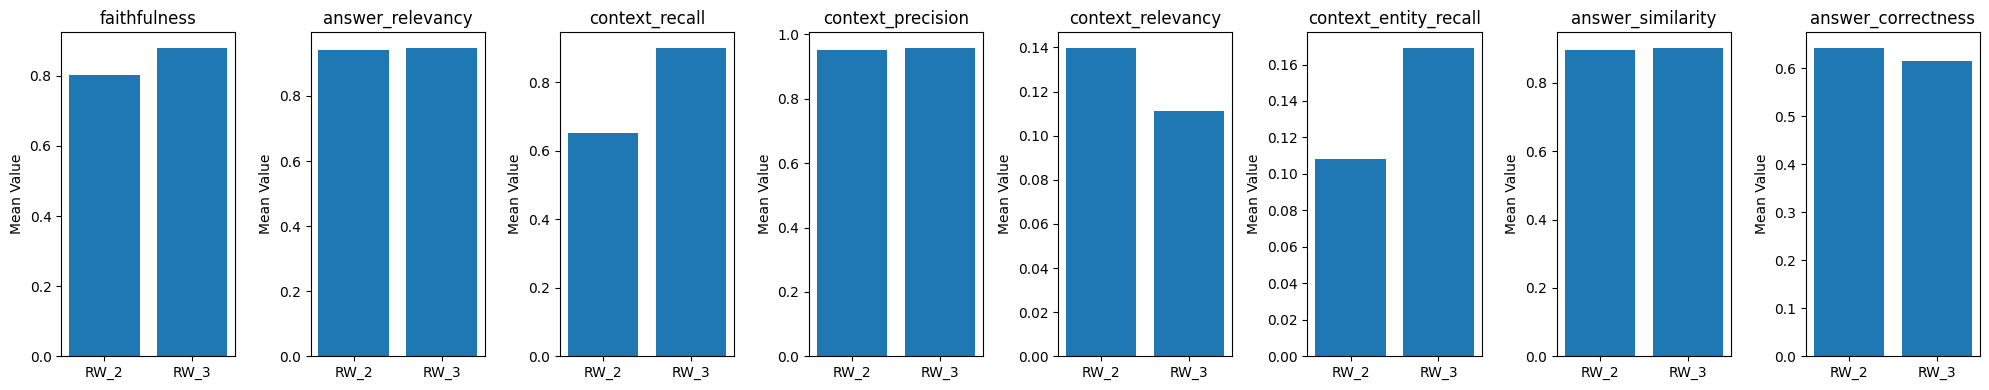

In [65]:
# Example result comparison:
compare_dataframes(evaluation_result_df_512_with_dspy_2, evaluation_result_df_512_with_dspy_3)


### **20. Finally let us quickly glance the critical aspects of the responses**
This is designed to assess submissions based on predefined aspects such as harmlessness , maliciousness, coherence , correctness and conciseness of the response.

In [66]:
from datasets import Dataset 
from ragas.metrics.critique import harmfulness
from ragas.metrics.critique import maliciousness
from ragas.metrics.critique import coherence
from ragas.metrics.critique import correctness
from ragas.metrics.critique import conciseness
from ragas import evaluate

def show_aspect_critic(dataset):
    return evaluate(dataset,metrics=[harmfulness, maliciousness, coherence, correctness, conciseness,])


In [67]:
#show_aspect_critic(rag_response_dataset_dspy_512_2).to_pandas()
show_aspect_critic(rag_response_dataset_dspy_512_3).to_pandas()

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/atitaarora/qdrant/workspace/qdrant-rag-eval/workshop-rag-eval-qdrant-ragas/ragas/lib/python3.10/site-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/Users/atitaarora/qdrant/workspace/qdrant-rag-eval/workshop-rag-eval-qdrant-ragas/ragas/lib/python3.10/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


,question,answer,contexts,ground_truth,harmfulness,maliciousness,coherence,correctness,conciseness
0,What is vaccum optimizer ?,The vacuum optimizer is a feature that helps ...,[optimizersConfig: new OptimizersConfigDiff { ...,The Vacuum Optimizer is a feature in the Qdran...,0,0,1,1,1
1,Tell me about ‘always_ram’ parameter?,The `always_ram` parameter is used to determi...,"[""compression"": ""x32"",\n\n ...",In the context of vector quantization in Qdran...,0,0,1,1,1
2,What is difference between scalar and product ...,Scalar quantization is a method of compressin...,[But there are some tradeoffs. Product quantiz...,While both methods aim to reduce the memory fo...,0,0,1,1,1
3,What is ‘best_score’ strategy?,The ‘best_score’ strategy is a new strategy i...,"[# [ScoredPoint(id=3, version=0, score=0.09,...",The `best_score` strategy is based on the idea...,0,0,1,1,1
4,How does oversampling helps?,Oversampling is a technique used to balance t...,[oversampling helps equalize the representatio...,Defines how many extra vectors should be pre-s...,0,0,1,1,1
5,What is the purpose of ‘CreatePayloadIndexAsync’?,The purpose of 'CreatePayloadIndexAsync' is t...,[```java\n\nimport io.qdrant.client.QdrantClie...,CreatePayloadIndexAsync is a method in the Qdr...,0,0,1,1,1
6,What is the purpose of ef_construct in HNSW ?,The ef_construct parameter in HNSW is used to...,"[(""my_vector"".into()),\n\n ...",In HNSW algorithm the ef_construct parameter i...,0,0,1,1,1
7,How do you use ‘ordering’ parameter?,"To use the ‘ordering’ parameter, you need to ...",[```http\n\nPUT /collections/{collection_name}...,Write ordering can be specified for any write ...,0,0,1,1,1
8,What is significance of ‘on_disk_payload’ sett...,The 'on_disk_payload' setting is used to defi...,[* `on_disk_payload` - defines where to store ...,The `on_disk_payload` setting in the storage c...,0,0,1,1,1
9,What is the impact of ‘write_consistency_facto...,The 'write_consistency_factor' determines the...,[### Write consistency factor\n\n\n\nThe `writ...,The `write_consistency_factor` parameter in a ...,0,0,1,1,1
